# 3 Qubit Error Correcting Code

In [2]:
# Importing math and plotting libraries
import numpy as np
import random
import matplotlib.pyplot as plt

# Importing some helpers that we will use throughout
from general_qec.qec_helpers import *
from general_qec.gates import *
from circuit_specific.three_qubit_helpers import *

# Importing required libraries for qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit import user_config
from qiskit.quantum_info import partial_trace
from qiskit.extensions import UnitaryGate

# For creating tables:
from tabulate import tabulate
# from prettytable import PrettyTable

# Initialize backends simulators to visualize circuits
sv_sim = Aer.get_backend('statevector_simulator')
qasm_sim = Aer.get_backend('qasm_simulator')

# Setting mpl as default drawer
%env QISKIT_SETTINGS {}
user_config.set_config('circuit_drawer', 'mpl')


env: QISKIT_SETTINGS={}


### It is important to note that when we measure the logical states of our qubit systems we will only actually "see" one of the states that make up our superposition terms of our qubit system state. This will happen in many notebooks but it is important to keep in mind that it is only for example's sake.

For example, if our state is $\vert\psi\rangle = \alpha\vert000\rangle + \beta\vert111\rangle$ we will either measure $\vert000\rangle$ or $\vert111\rangle$, never both! 

Another useful example that well come across is when we use ancilla qubits and measure them, collapsing our state. Lets say our state is $\vert\psi\rangle = \alpha_1\vert00001\rangle + \alpha_1\vert00010\rangle + \beta_2\vert11101\rangle + \beta_2\vert11110\rangle$. And lets say we measure our two ancilla qubits at the end (right side of our bit representation). The the states we would get are $\vert\psi\rangle = \gamma_1\vert00001\rangle + \lambda_1\vert11101\rangle$ or $\vert\psi\rangle = \gamma_2\vert00010\rangle + \lambda_2\vert11110\rangle$, but again never both!

### In our notebooks, we just display this information to show the current quantum state, although physically this would never be possible.

## Contents
1. [Introduction](#introduction)
2. [Initializing the 3-qubit logical state](#initialize)
    1. [CNOT gates for initialization](#cnotinitialize)
3. [Encoding and correcting for a single X error](#encode)
    1. [CNOT Gates for error detection](#cnotdetection)
    2. [How do we detect and correct for errors](#howdetect)
    3. [Implementing our Error Correction](#implement)
4. [A more physically realistic example](#realistic)
    1. [Error Correction](#realisticcorrection)
    2. [Fidelity Results](#fidelity)

## 1. Introduction <a id='introduction'></a>
### In this nnotebook we will introduce the 3 qubit code and demonstrate how it works as well as create a running example. We will only use numpy to derive the math as well as create the algorithm, while qiskit will only be used to draw the circuits so that we are able to visualize them.

#### Below we show the Pauli Operators which can be used to describe many quantum gates on individual qubits. We will use and reference these throughout. As you can see, a gate on an individual qubit is represented by a 2x2 matrix. Thus when we apply an operation, $U$, on a qubit state say $\vert\psi\rangle$ , which is a 2x1 vector, we will get $U\vert\psi\rangle$ which is still a 2x1 vector state.

In [ ]:
print('Pauli-X: \n', sigma_x) 
print('Pauli-Y: \n', sigma_y)
print('Pauli-Z: \n', sigma_z)
print('Pauli-I: \n', sigma_I)

## 2. Initializing the 3-qubit logical state <a id='initialize'></a>
#### The 3 Qubit code is the most basic algorithm used for quantum error correction. However, it does not actually represent a full quantum code since it cannot simultaneously correct for bit flips and phase flips.
#### In this algorithm a single logical qubit is encoded using 3 physical qubits, and it is able to correct for a single $\sigma_x$ error (bit flip). This is like having a sort of 'repeater' that has the information encoded multiple times so that if errors do occur in a single physical qubit, we are able to see them and (hopefully) correct for them.

#### In this case we will define our two logical states as $\vert0\rangle_L$ and $\vert1\rangle_L$ where $\vert0\rangle_L = \vert000\rangle$ and $\vert1\rangle_L = \vert111\rangle$

#### Thus a single qubit state will be represented by $\vert\psi\rangle_L = \alpha\vert0\rangle_L + \beta\vert1\rangle_L$

#### Below we show the quantum circuit for encoding a single logical qubit. Here we use two ancilla qubits initialized to $\vert0\rangle$ and two CNOT gates.

#### CNOT gates can be represented with the matrix below and it performs an operation on two qubits. One being the target qubit and the other the control. Basically, if the control is $\vert0\rangle$ then nothing happens, but if the control is $\vert1\rangle$ then the target qubit switches states, either to a $\vert0\rangle$ or $\vert1\rangle$

#### CNOT gate matrix representation:  $$\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}$$


In [ ]:
psi = QuantumRegister(1, '|ψ⟩')
ancilla = QuantumRegister(2, '|0⟩')
qc = QuantumCircuit(psi, ancilla)
qc.cnot(0, 1)
qc.cnot(1, 2)
qc.draw()

### A. CNOT gates for initialization <a id='cnotinitialize'></a>
#### Mathematically we are able to show what this would look like in terms of matrices and vectors. Our operation will look something like:
$$ CNOT_{\psi, 0} CNOT_{0, 1} \vert\psi\rangle \vert0\rangle_0 \vert0\rangle_0 = CNOT_{\psi, 0} CNOT_{0, 1} \vert\psi 0_0 0_1\rangle$$
#### Where $CNOT_{\psi, 0}$ is the CNOT operation with qubit $\vert0\rangle_0$ as the target and qubit $\vert\psi\rangle$ as the control, and $CNOT_{0, 1}$ is the CNOT operation with qubit $\vert1\rangle_0$ as teh target and qubit $\vert0\rangle_0$ as the control. $\vert\psi\rangle$, $\vert0\rangle_0$, and $\vert0\rangle_1$ are the initial states for the three qubits respectively.
#### Operations on multiple qubits: https://learn.microsoft.com/en-us/azure/quantum/concepts-multiple-qubits
#### In order to achieve this initialization we need to derive two operators (the CNOT gates). Although they are the same gate, the operators themselves will look slightly different due to the fact that our qubit $\vert\psi\rangle$ is acting on qubit $\vert0\rangle_0$, and $\vert0\rangle_0$ is acting on qubit $\vert0\rangle_1$. We know that the dimensions of our operations $CNOT_{\psi, 0}$ and  $CNOT_{0, 1}$ should be 8 x 8 matrices. This is due to the fact that $\vert\psi 0_0 0_1\rangle$ is an 8 x 1 vector and we want to arrive at a vector of the same dimension in the end.

#### Thus for the first CNOT on $\vert0\rangle_0$ we know that the operation should not affect qubit $\vert0\rangle_1$. Therefore we know that $CNOT_{\psi, 0} = CNOT \otimes I_2$ where CNOT is our usual CNOT operation between $\vert\psi\rangle$ and $\vert0\rangle_0$ defined above and $I_2$ is the 2 x 2 identity matrix for $\vert0\rangle_1$. Also $CNOT_{0, 1} = I_2 \otimes CNOT$ where CNOT is our usual CNOT operation between $\vert0\rangle_0$ and $\vert0\rangle_1$ defined above and $I_2$ is the 2 x 2 identity matrix for $\vert\psi\rangle_1$. Thus 

$$CNOT_{\psi, 0} = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0
\end{pmatrix},\quad and \quad
CNOT_{0, 1} = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0
\end{pmatrix}$$

#### Below is a function that implements the 3-qubit code shown in the circuit above for initializing the logical state of the system


In [ ]:
psi = one
final_logical_state = three_qubit_initialize_logical_state(psi)
print('Psi State: ', psi)
print('Final Logical State:')
print_state_info(final_logical_state, 3)

## 3. Encoding and correcting for a single X error <a id='encode'></a>
#### One thing to note about the circuit above is that three bit flips are required to encode a single qubit. This number is defined as the distance between two codeword states and is given the variable d. With this we are able to calculate the number of errors that can be corrected:
$$ t = \left\lfloor \frac{(d-1)}{2} \right\rfloor$$
#### In the case of the 3 qubit code, we can see that d = 3 and thus t = 1

#### Now in order to actually be able to correct for errors we require two more ancilla qubits to obtain information about possible errors (syndrome information) without directly measuring the exact state of any of the qubits in the logical qubit.
#### Our new circuit will now look like this:

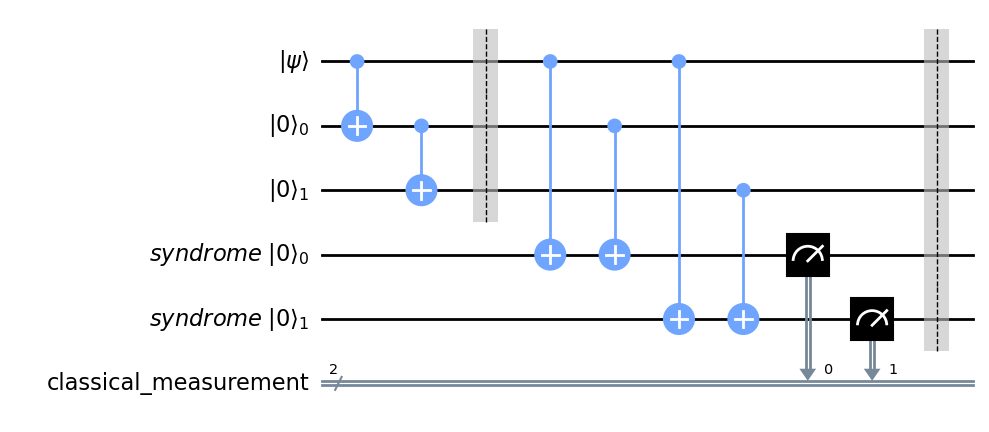

In [3]:
psi = QuantumRegister(1, '|ψ⟩')
ancilla = QuantumRegister(2, '|0⟩')
syndrome_ancilla = QuantumRegister(2, 'syndrome |0⟩')
classical_bits = ClassicalRegister(2, 'classical_measurement')
qc = QuantumCircuit(psi, ancilla, syndrome_ancilla, classical_bits)
qc.cnot(0, 1)
qc.cnot(1, 2)
qc.barrier(0,1,2) # A bit flip error occurs here
qc.cnot(0, 3)
qc.cnot(1, 3)
qc.cnot(0, 4)
qc.cnot(2, 4)
qc.measure(syndrome_ancilla, classical_bits)
qc.barrier()
qc.draw()

#### The first dashed line represents the bit flip (X) error that occurs to any of the first 3 data qubits. After that we apply 4 CNOT gates to obtain the error information. Then we classically measure the syndrome qubits to see if an error occured and where the error is. 

#### In this example we assume that the error only occurs where the dashed line is and all other gate operations are 'perfect'. Additionally we assume that only a single bit flip error occurs.

#### Now we will simulate what would happen if a single X bit flip error occurs at a random location after we have initialized the 3 qubit logical state. We can mathematically represent each errror at a location as the following:

#### If the error occurs at the 0th qubit ($\vert\psi\rangle$): $(X \otimes I_2 \otimes I_2)\vert\psi q_1 q_2 \rangle$
#### If the error occurs at the 1st qubit ($\vert q_1\rangle$): $(I_2 \otimes X \otimes I_2)\vert\psi q_1 q_2 \rangle$
#### If the error occurs at the 2nd qubit ($\vert q_2\rangle$): $(I_2 \otimes I_2 \otimes X)\vert\psi q_1 q_2 \rangle$
#### Where X is the Pauli-x ($\sigma_x$) operator

In [ ]:
# Print out the errored logical state and the index qubit which the error occured (using the final state from before)
state, qubit_errored = three_qubit_random_qubit_x_error(final_logical_state)
print('Logical State without the random X error: ')
print_state_info(final_logical_state, 3)
print('Logical Satte with the random X error:    ')
print_state_info(state, 3)
print('The Error occured at qubit: ', qubit_errored)

### A. CNOT Gates for error detection <a id='cnotdetection'></a>
#### Next we need to be able to find where the qubit errored without directly knowing where it errored (kind of counter intuitive). Since this is a simulation we are able to print out what index the qubit actaully errored at to check our work, but in reality we wont know. So we should have a way to determine this. That is where our syndrome ancilla qubits come into play. They will tell us where our error occured!

#### Below we derive each CNOT gate represented in the ciruit above as a 32 x 32 matrix. Since the matrix is too large to show, we can follow a different process to deriving the CNOT gates than we did earlier for the logical state initialization. 

#### We will be using the following derivation method for a CNOT gate with one qubit in between the control and target qubits (thus the qubits that the gate acts on are non-adjacent). For this CNOT gate it is not so simple, like our previous derivation for a 3-qubit CNOT since there is no known kronecker product that would lead to the transformation needed. Thus we can derive it by looking at what happens to the logical states of the qubit when we apply this gate.
https://quantumcomputing.stackexchange.com/questions/4252/how-to-derive-the-cnot-matrix-for-a-3-qubit-system-where-the-control-target-qu/4254#4254

$$ CNOT\vert000\rangle \to \vert000\rangle = [1 0 0 0 0 0 0 0 ]^T\\ CNOT\vert001\rangle \to \vert001\rangle = [0 1 0 0 0 0 0 0 ]^T \\
CNOT\vert010\rangle \to \vert010\rangle = [0 0 1 0 0 0 0 0 ]^T\\ CNOT\vert011\rangle \to \vert011\rangle = [0 0 0 1 0 0 0 0 ]^T \\
CNOT\vert100\rangle \to \vert101\rangle = [0 0 0 0 0 1 0 0 ]^T\\ CNOT\vert101\rangle \to \vert100\rangle = [0 0 0 0 1 0 0 0 ]^T \\
CNOT\vert110\rangle \to \vert111\rangle = [0 0 0 0 0 0 0 1 ]^T\\ CNOT\vert111\rangle \to \vert110\rangle = [0 0 0 0 0 0 1 0 ]^T $$

#### Now if you look closely when we put these together as the collumns of out matrix we get:


$$ CNOT_{\psi, 1} = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0
\end{pmatrix}$$

#### Which is the matrix representation for the CNOT gate when our 2 qubits are not adjacent in the 3-qubit system.

### Instead of using the tedious method from above everytime we want to find a CNOT gate between 2 non-adjacent qubits, the following function was created to make a matrix representation of a non-adjacent CNOT gate

#### Below I construct a function to create a non-adjacent CNOT gate for any number of qubits in between the control and target. The reference I use is Proposition 8 of this document:
https://hal-normandie-univ.archives-ouvertes.fr/hal-02948598/document

#### Where we let $ i_1, i_2, ..., i_p \space (p - 1 \ge 2) $ be distinct integers such that
$$ CNOT_{i_1, i_p} = \biggl(CNOT_{i_1, i_2}CNOT_{i_2, i_3} . . . CNOT_{i_{p-2}, i_{p-1}}CNOT_{i_{p-1}, i_p}CNOT_{i_{p-2}, i_{p-1}} . . . CNOT_{i_2, i_3}\biggr)^2 $$

#### This is simply used to construct the non-adjacent CNOT gate matrix, thus we do not take into account the individual gate errors that go into making the full gate. However, in the future we may do this.

In [ ]:
print(non_adj_CNOT(0, 2, 3))

### Below is the code to put together the 4 CNOT gates after initializing the 3 qubit logical state and then applying a random error. Note that the error function has 4 options, error on qubit 0, error on qubit 1, error on qubit 2, or no error at all.

In [ ]:
# Code implementing the Syndrome Ancilla Qubits to check where the error occured
initial_psi = one

# Initialize our system and apply an X error
initial_state = three_qubit_initialize_logical_state(initial_psi) # Initialize our 3 qubit logical state
error_state = three_qubit_random_qubit_x_error(initial_state)[0] # Apply a random X error to one of our 3 qubits

# Find the vector state representation after applying the ancilla qubits
final_state = three_qubit_apply_ancillas(error_state)
print(final_state.astype(int))

### B. How do we detect and correct for errors <a id='howdetect'></a>
#### We can now construct a table with the possible results of bit flip error which can occur and how we will detect them using the two syndrome ancilla qubits. For each different error, the syndrome ancillas are flipped to a unique state which we can then measure and apply a correction. The $\sigma_x$ or bit flip correction would be classically controlled depending on the syndrome ancilla.

In [ ]:
error_table = PrettyTable(["Error Location", "Final State, |data⟩|ancilla⟩"])
 
error_table.add_row(["No Error", "alpha|000⟩|00⟩ + beta|111⟩|00⟩"])
error_table.add_row(["Qubit 0 (|ψ⟩)", "alpha |100⟩|11⟩ + beta|011⟩|11⟩"])
error_table.add_row(["Qubit 1 (|0⟩_0)", "alpha |010⟩|10⟩ + beta|101⟩|10⟩"])
error_table.add_row(["Qubit 2 (|0⟩_1)", "alpha |001⟩|01⟩ + beta|110⟩|01⟩"])
 
print(error_table)

#### However it is important to note that this 3 qubit code can only correct a maximum of one bit flip error on a single qubit. Anything else will cause ambiguity of syndrome results. This can be seen in the table below where we see multiple errors occuring and the assumed error that our ancilla tell us.

In [ ]:
multi_error_table = PrettyTable(["Error Location", "Final State, |data⟩|ancilla⟩", "Assumed Error"])
 
multi_error_table.add_row(["Qubit 0 and 1", "alpha|110⟩|01⟩ + beta|001⟩|01⟩", "sigma_x on Qubit 2"])
multi_error_table.add_row(["Qubit 1 and 2", "alpha |011⟩|11⟩ + beta|100⟩|11⟩", "sigma_x on Qubit 0"])
multi_error_table.add_row(["Qubit 0 and 2", "alpha |101⟩|10⟩ + beta|010⟩|10⟩", "sigma_x on Qubit 1"])
multi_error_table.add_row(["Qubit 0, 1, and 2", "alpha |111⟩|00⟩ + beta|000⟩|00⟩", "no error"])

print('We can see that with multiple errors occuring at different qubits we would not be able to tell what is going on.')
print(multi_error_table)

### Thus from above we can see that our tensored vectors will look different depending on where the error is.


In [ ]:
# When the Initial Logical State is |0>
a = 0
b = 1
print('When the Initial Logical State is |0>')
print('No Error: ', a * np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, zero)))).astype(int) +
     b * np.kron(one, np.kron(one, np.kron(one, np.kron(zero, zero)))).astype(int))
print('Error on 0th qubit: ', a * np.kron(one, np.kron(zero, np.kron(zero, np.kron(one, one)))).astype(int) +
     b * np.kron(zero, np.kron(one, np.kron(one, np.kron(one, one)))).astype(int))
print('Error on 1st qubit: ', a * np.kron(zero, np.kron(one, np.kron(zero, np.kron(one, zero)))).astype(int) +
     b * np.kron(one, np.kron(zero, np.kron(one, np.kron(one, zero)))).astype(int))
print('Error on 2nd qubit: ', a * np.kron(zero, np.kron(zero, np.kron(one, np.kron(zero, one)))).astype(int) +
     b * np.kron(one, np.kron(one, np.kron(zero, np.kron(zero, one)))).astype(int))
# When the Initial Logical State is |1> 
a = 1
b = 0
print('\nWhen the Initial Logical State is |1>')
print('No Error: ', a * np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, zero)))).astype(int) +
     b * np.kron(one, np.kron(one, np.kron(one, np.kron(zero, zero)))).astype(int))
print('Error on 0th qubit: ', a * np.kron(one, np.kron(zero, np.kron(zero, np.kron(one, one)))).astype(int) +
     b * np.kron(zero, np.kron(one, np.kron(one, np.kron(one, one)))).astype(int))
print('Error on 1st qubit: ', a * np.kron(zero, np.kron(one, np.kron(zero, np.kron(one, zero)))).astype(int) +
     b * np.kron(one, np.kron(zero, np.kron(one, np.kron(one, zero)))).astype(int))
print('Error on 2nd qubit: ', a * np.kron(zero, np.kron(zero, np.kron(one, np.kron(zero, one)))).astype(int) +
     b * np.kron(one, np.kron(one, np.kron(zero, np.kron(zero, one)))).astype(int))

### C. Implementing our Error Correction <a id='implement'></a>
### The function below was made to be able to detect where the error occurs:

In [ ]:
three_qubit_detect_error_location_from_vector(final_state)

### Now to correct the error:

In [ ]:
print(three_qubit_correct_x_error(final_state).astype(int))

#### Below we take the qubit state (32 element array) and take only the first 3 qubits to make sure that the correction worked. This is the full error correction procedure.

In [ ]:
# Our initial single qubit state (Psi) # |0> or |1>
initial_psi = one

# Initialize our 3 qubit logical state and apply an X error
initial_state = three_qubit_initialize_logical_state(initial_psi) # Initialize our 3 qubit logical state
error_state = three_qubit_random_qubit_x_error(initial_state)[0] # Apply a random X error to one of our 3 qubits
# Now we can apply the CNOT gates to combine our 3 qubit logical state with the 2 syndrome ancillas
full_error_state = three_qubit_apply_ancillas(error_state)


# Next we correct the final state of our system
corrected_state = three_qubit_correct_x_error(full_error_state)
print('Error State:     ', full_error_state.astype(int))
print('Corrected State: ', corrected_state.astype(int))

# Output the 3 qubit logical state with the error
print('Error logical state:     ', vector_state_to_bit_state(full_error_state, 3)[0][0])
# Output our corrected 3 qubitlogical state
print('Corrected logical state: ',vector_state_to_bit_state(corrected_state, 3)[0][0])

### Running our 3 qubit code again but with our initial state being some $\alpha\vert0\rangle_L + \beta\vert1\rangle_L$

In [ ]:
# Our initial single qubit state (Psi) # alpha |0>  + beta |1>
initial_psi = 1/np.sqrt(2)* np.array([1, 1]) 
# initial_psi = np.array([0, 1])

# Initialize our 3 qubit logical state and apply an X error
initial_state = three_qubit_initialize_logical_state(initial_psi) # Initialize our 3 qubit logical state
error_state = three_qubit_random_qubit_x_error(initial_state)[0] # Apply a random X error to one of our 3 qubits
# Now we can apply the CNOT gates to combine our 3 qubit logical state with the 2 syndrome ancillas
full_error_state = three_qubit_apply_ancillas(error_state)


# Next we correct the final state of our system
full_corrected_state = three_qubit_correct_x_error(full_error_state)


# Output the 5 qubit logical state with the error
error_logical_bits, error_index, error_state = vector_state_to_bit_state(full_error_state, 5)

three_qubit_info(error_state, full_corrected_state)

## 4. A more physically realistic example <a id='realistic'></a>
#### Next we will consider a different and more physically realistic example by assuming that the errors acting on the qubits are coherent rotations in the form $U = e^{i\epsilon\theta_x}$ on each qubit and $\epsilon << 1$ will be assumed

#### The coherent rotations are used in order to be able to represent the state as a state vector rather than having to move to the density matrix.

#### Lets assume each qubit experiences the same error: $\vert\psi\rangle_E = E\vert\psi\rangle$ , where 
$$ E = U^{\otimes3} = (cos(\epsilon)\sigma_I + isin(\epsilon)\sigma_x)^{\otimes3}$$ $$= c_0\sigma_I\sigma_I\sigma_I + c_1(\sigma_x\sigma_I\sigma_I + \sigma_I\sigma_x\sigma_I + \sigma_I\sigma_I\sigma_x) + c_2(\sigma_x\sigma_x\sigma_I + \sigma_I\sigma_x\sigma_x + \sigma_x\sigma_I\sigma_x) + c_3\sigma_x\sigma_x\sigma_x$$
#### Where $$ c_0 = cos^3(\epsilon), \quad c_1 = icos^2(\epsilon)sin(\epsilon), \quad c_2 = -cos(\epsilon)sin^2(\epsilon), \quad c_3 = -isin^3(\epsilon)$$

#### Now we can run our QEC using the 2 ancilla qubits: 
$$ U_{QEC}(E\vert\psi\rangle_L\vert00\rangle) = U_{QEC}\biggl(\biggl( c_0\sigma_I\sigma_I\sigma_I + c_1 (\sigma_x\sigma_I\sigma_I + \sigma_I\sigma_x\sigma_I + \sigma_I\sigma_I\sigma_x) + c_2 (\sigma_x\sigma_x\sigma_I + \sigma_I\sigma_x\sigma_x + \sigma_x\sigma_I\sigma_x) + c_3\sigma_x\sigma_x\sigma_x\biggr)\vert00\rangle\biggr) $$
$$ = c_0\sigma_I\sigma_I\sigma_I\vert00\rangle + c_1\sigma_x\sigma_I\sigma_I\vert11\rangle + c_1\sigma_I\sigma_x\sigma_I\vert10\rangle + c_1\sigma_I\sigma_I\sigma_x\vert01\rangle + c_2\sigma_x\sigma_x\sigma_I\vert10\rangle + c_2\sigma_I\sigma_x\sigma_x\vert11\rangle + c_2\sigma_x\sigma_I\sigma_x\vert01\rangle + c_3\sigma_x\sigma_x\sigma_x\vert00\rangle $$

#### Next we measure the ancilla block and apply the correction. As we can see in the table below, after each correction we have a superposition of a logically correct state and a logically flipped state. 

In [ ]:
ancilla_measurement_table = PrettyTable(["Ancilla Measurement", "Corrected State"])
 
ancilla_measurement_table.add_row(["|00⟩", "c_0|ψ⟩_L + c_3 σ_x σ_x σ_x |ψ⟩_L "])
ancilla_measurement_table.add_row(["|11⟩", "c_1|ψ⟩_L + c_2 σ_x σ_x σ_x |ψ⟩_L"])
ancilla_measurement_table.add_row(["|10⟩", "c_1|ψ⟩_L + c_2 σ_x σ_x σ_x |ψ⟩_L"])
ancilla_measurement_table.add_row(["|01⟩", "c_1|ψ⟩_L + c_2 σ_x σ_x σ_x |ψ⟩_L"])
 
print(ancilla_measurement_table)

### Calculating the fidelity associated with each term:

#### Fidelity without any error correction:
#### $$F_{UNENCODED} = \vert\langle\psi\vert U \vert\psi\rangle\vert^2 = \vert\biggl(\alpha\langle0_L\vert + \beta\langle1\vert_L \biggr)\biggl((cos(\epsilon) + isin(\epsilon)\alpha\vert0\rangle_L + (cos(\epsilon) + isin(\epsilon)\beta\vert1\rangle_L\biggr)\vert^2 $$ $$= \vert\alpha^2(cos(\epsilon) + isin(\epsilon)) + \beta^2(cos(\epsilon) + isin(\epsilon)\vert^2 = \vert(\alpha^2 + \beta^2)(cos(\epsilon) + isin(\epsilon))\vert^2 = \biggl(\vert\alpha\vert^2 + \vert\beta\vert^2\biggr)^2cos^2(\epsilon) + \biggl(\alpha\beta^* + \alpha^*\beta\biggr)^2sin^2(\epsilon)$$

#### Now lets let $\vert\psi\rangle_L = \vert0\rangle_L$ or $\vert1\rangle_L$, lets say $\vert0\rangle_L$ in this case. so now we have either $\alpha = 1$ and $\beta = 0$ or $\alpha = 0$ and $\beta = 1$ (the 2nd term above is 0 and the first goes to $cos^2(\epsilon)$. Thus using small angle approximation $(\epsilon<<1)$ we can see that $ F_{UNENCODED} = cos^2(\epsilon) \approx 1-\epsilon^2$

#### Fidelity after error correction:
$$ F_{NO\space ERROR\space DETECTED} = \frac{\vert Desired\space State\vert^2}{\vert Desired\space State\vert^2 + \vert Error\space State\vert^2} = \frac{\vert c_0 \vert^2}{\vert c_0\vert^2 + \vert c_3\vert^2} = \frac{cos^6(\epsilon)}{cos^6(\epsilon) + sin^6(\epsilon)} \approx 1 - \epsilon^6$$


$$ F_{ERROR\space DETECTED} = \frac{\vert Desired\space State\vert^2}{\vert Desired\space State\vert^2 + \vert Error\space State\vert^2} = \frac{\vert c_1 \vert^2}{\vert c_1\vert^2 + \vert c_2\vert^2} = \frac{cos^4(\epsilon)sin^2(\epsilon)}{cos^4(\epsilon)sin^2(\epsilon) + cos^2(\epsilon)sin^4(\epsilon)} \approx 1 - \epsilon^2$$


#### As we can see above, the fidelity when no error is detected the error state is surpressed from $O(\epsilon^2)$ to $O(\epsilon^6)$ and fidelity increases, while when detecting an error we can see that the error state remains the same and so does our fidelity compared to when we do not encode the system using syndrome ancilla.
#### Since $\epsilon^2 << 1$ we can see that most of the time we will not detect an error, thus our overall fidelity will improve.
#### It is important to note that we will never be able to achieve 100% fidelity simply because the final logical state will always contain some superposition (mixture) of the desired state and error state when dealing with coherent (incoherent) errors.

#### We can also calculate the probability of having each of these outcomes occur. This can be done by using the magnitude of the resulting logical states after the round of error correction since we know that the probability of being in a certain state say $\vert0\rangle$ is $P(\vert0\rangle) = \alpha^2$ and for $\vert1\rangle$ is $P(\vert1\rangle) = \beta^2$ when $\vert\psi\rangle = \alpha\vert0\rangle + \beta\vert1\rangle$.

#### Thus for no error being detected we have a probability of
$$ P_{NO\space ERROR\space DETECTED} = \vert cos^3(\epsilon) - isin^3(\epsilon)\vert^2 = cos^6(\epsilon) + sin^6(\epsilon) \approx 1 - 3\epsilon^2 + O(\epsilon^4)$$
#### And our probability of detecting an error is 
$$ P_{ERROR\space DETECTED} = 3 \vert icos^2(\epsilon)sin(\epsilon) - cos(\epsilon)sin^2(\epsilon)\vert^2 = 3 ( cos^4(\epsilon)sin^2(\epsilon) + cos^2(\epsilon)sin^4(\epsilon)) \approx 3\epsilon^2 + O(\epsilon^4)$$

### A. Error Correction <a id='realisticcorrection'></a>
### Below we implement this error model to the 3 qubit code to be able to see how our error correction works now that we have a more realistic error.

### Applying a small epsilon error to each qubit and applying our usual quantum error correction to our system

In [ ]:
# Initialize our 3 qubit logical state
psi = one

initial_state = three_qubit_initialize_logical_state(psi)
epsilon = np.deg2rad(1)

# Apply a coherent error to each of our 3 qubits
error_state, E, U = three_qubit_coherent_x_rotation_error(initial_state, epsilon, 3)

# Now we can apply the CNOT gates to combine our 3 qubit logical state with the 2 syndrome ancillas
full_error_state = three_qubit_apply_ancillas(error_state)

# Find the error states in bit form for plotting later on
error_logical_bits, error_index, error_state = vector_state_to_bit_state(full_error_state, 5)


corrected_states, corrected_bit_states = separate_and_correct_multiple_errors(error_state, 5)

# For outputting purposes we only need the non zero values, and since the bits are in the same order as the arrays
# we can just find the nonzero values in each correct vector to know the magnitude of that state.
error_state = error_state[error_state != 0]
corrected_states = corrected_states[corrected_states != 0]


### B. Fidelity Results <a id='fidelity'></a>
### Below we plot the probabilites of being in different states after an error has occured with no correction and after our quantum error correction protocols. We are able to see 2 key ideas from these plots:
#### 1. The fidelity of detecting no error changes between applying quantum error correction protocols or not. We can see the states ($\vert\psi\rangle_L \vert00\rangle$ and $\sigma_X\sigma_X\sigma_X\vert\psi\rangle_L \vert00\rangle$) have the same probabilites, but if we calculate the fidelity we will see that there is a difference in the expectation value for the unencoded state.
#### 2. The fidelity of detecting an error does change between applying quantum error correction protocols or not. We can see that when not applying error correction we get the six states ($\sigma_x\sigma_I\sigma_I\vert11\rangle, \space\sigma_I\sigma_x\sigma_I\vert10\rangle, \space\sigma_I\sigma_I\sigma_x\vert01\rangle, \space\sigma_x\sigma_x\sigma_I\vert10\rangle, \space\sigma_I\sigma_x\sigma_x\vert11\rangle, and \space\sigma_x\sigma_I\sigma_x\vert01\rangle $) which all contain errors at some probabilty. However, when we apply our error correction, the states from above will be corrected, however the states will still have some probability they will be correct but at another they will be incorrect.

#### These are the reasons we choose to still implement QEC even when we have multiple errors on our system. Our overall fidelity will still increase, due to the fidelity increase when we do not detect an error.

In [ ]:
# Plotting the error state probabilities
fig, ax = plt.subplots()
fig.set_figwidth(20)
error_state_bars = ax.bar(error_logical_bits, np.abs(
    error_state)**2, label = 'Error States Distribution', color = 'tomato')
plt.title('Probability Distribution of Error States')
plt.xlabel('logcial bit states') 
plt.ylabel('probability') 
ax.bar_label(error_state_bars)
plt.show()

# Plotting the corrected state probabilities
fig, ax = plt.subplots()
fig.set_figwidth(20)
corrected_state_bars = ax.bar(corrected_bit_states, np.abs(
    corrected_states)**2, label = 'Corrected States Distribution', color = 'deepskyblue')
plt.title('Probability Distribution of Corrected States')
plt.xlabel('logcial bit states') 
plt.ylabel('probability') 
ax.bar_label(corrected_state_bars)
plt.show()

### Now to calculate the fidelities of our system

In [ ]:
# Unencoded Fidelity:
F_unencoded = (np.cos(epsilon))**2

# Encoded Fidelity with no error detected:
F_no_error_detected = ((np.cos(epsilon))**6)/((np.cos(epsilon))**6 + (np.sin(epsilon))**6)
Prob_no_error_detected = (np.cos(epsilon))**6 + (np.sin(epsilon))**6

# Encoded Fidelity with error detected:
F_error_detected = (((np.cos(epsilon))**4)*(np.sin(epsilon))**2)/(((np.cos(epsilon))**4)*(np.sin(epsilon))**2 + ((np.sin(epsilon))**4)*(np.cos(epsilon))**2)
Prob_error_detected = 3*((np.cos(epsilon)**4 * (np.sin(epsilon))**2) + (np.sin(epsilon)**4 * (np.cos(epsilon))**2))

print('Unencoded Fidelity:   ', F_unencoded)
print('Encoded No Error Detected Fidelity: ', F_no_error_detected, ', with a probability of ', Prob_no_error_detected)
print('Encoded Error Detected Fidelity: ', F_error_detected, ', with a probability of ', Prob_error_detected)
print(' - - - - - - - - - -')
print('New Encoded Fidelity: ', F_no_error_detected*Prob_no_error_detected + F_error_detected*Prob_error_detected)

### Congrats! You have finished learning about the three qubit single bit flip error correcting code.

### Extra resources that could be helpful :)

https://qiskit.org/documentation/stable/0.35/tutorials/circuits/3_summary_of_quantum_operations.html

https://www.oreilly.com/library/view/qiskit-pocket-guide/9781098112462/ch01.html

Fidelity:
https://www.frontiersin.org/articles/10.3389/fphy.2022.893507/full

General QEC:
http://theory.caltech.edu/~preskill/ph229/notes/chap7.pdf